# Data Import and Preperation

In [1]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
import eia
import seaborn as sns
import statistics
import os
import re
import random
from scipy.stats import zscore

In [2]:
df_g2 = pd.read_csv("../data/state_files.csv")
df_g2['particle_no'] = df_g2['name'].apply(
        lambda f: int(re.search(r"Particle_(\d{1,3})_", f).group(1)))
lst_singular = df_g2[df_g2.g2_tau_zero <0.5].particle_no.tolist()
lst_non_singular = df_g2[df_g2.g2_tau_zero >=0.5].particle_no.tolist()

# Data Generation with 3 States 
Use some fraction of the 170 samples as test and training data

In [12]:
X_overall = []
X_singular = []
Y_overall = []
count = 0
counter_non_singular = 0
lst_particle_no = []

particle_no_selection = [37,1] # Particles Numbers of Interst
X_selection = [] # MANUAL Selection (for testing purposes)
Y_selection = []

for filename in sorted(os.listdir("../data/")):
    if not filename.endswith("csvIntTrace.csv"):
        continue
        
    if count == 1:
        break
    
    df = pd.read_csv("../data/" + filename)
    
    df['z'] = zscore(df['y']) # z normalize the df 
    
    particle_no = int(re.search(r"Particle_(\d{1,3})_", filename).group(1))
    
    if particle_no in particle_no_selection:
        if particle_no in lst_singular:
            Y_selection.append(0)
        elif particle_no in lst_non_singular:
            Y_selection.append(1)
        else:
            Y_selection.append(2)
        X_selection.append(df.z.values.tolist())
            

    if particle_no in lst_singular:
        Y_overall.append(0)        
    elif particle_no in lst_non_singular:
        Y_overall.append(1)
        counter_non_singular = counter_non_singular + 1
    else:
        #pass #DO NOT Import the discarded states
        Y_overall.append(2)
    X_overall.append(df.z.values.tolist())
    lst_particle_no.append(particle_no)

    
index_train = []
while len(index_train) <= 136: #48 without discarded (Set the size of the training data)
    random_no = random.randint(0, len(Y_overall) - 1)
    if random_no not in index_train:
        index_train.append(random_no)
        
index_all = list(range(0, len(Y_overall) - 1))
index_test = list(set(index_all) - set(index_train))

In [5]:
# load a previously exported set of coefficients (HOWEVER this is currently not the particle number!!)
index_test = np.array(pd.read_csv("index_test.csv",header=None).values[:,0].tolist()).astype(int)
index_train = np.array(pd.read_csv("index_training.csv",header=None).values[:,0].tolist()).astype(int) #training index

In [13]:
X_overall = np.array(X_overall)
Y_overall = np.array(Y_overall)
X_selection = np.array(X_selection)
Y_selection = np.array(Y_selection)
lst_particle_no = np.array(lst_particle_no)

# Randomly shift the data
X_train = X_overall[index_train]
Y_train = Y_overall[index_train]
X_test = X_overall[index_test]
Y_test = Y_overall[index_test]
lst_particle_no_test = lst_particle_no[index_test]
lst_particle_no_train = lst_particle_no[index_train]

np.savetxt("index_test.csv", index_test)
np.savetxt("index_training.csv", index_train)
np.savetxt("lst_particle_no_test.csv", index_test)
np.savetxt("lst_particle_no_train.csv", index_train)


# Check for elements in Ytest
unique, counts = np.unique(Y_test, return_counts=True)
dict(zip(unique, counts))

{0: 5, 1: 5, 2: 23}

# Use all files w/ g2 Data as Training Data

The idea: the discarded g2 files might contain singular particles. The Data needs to be split in such a way that this data can still be used!

# Timeseries classification w/ my Data
#### ATTENTION: This is not my code! Please check the following link for the source and the corresponding paper
https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/timeseries/ipynb/timeseries_classification_from_scratch.ipynb#scrollTo=YaRrO6a0OxOf

https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

**Paper**: https://doi.org/10.48550/arXiv.1611.06455

In [15]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2023-01-21 19:40:51.656796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
X_overall_ = np.array(X_overall)
Y_overall_ = np.array(Y_overall)

# transform the timeseries into a multivariate one 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_selection = X_selection.reshape((X_selection.shape[0], X_selection.shape[1], 1))
X_overall_ = X_overall_.reshape((X_overall_.shape[0], X_overall_.shape[1], 1))

In [ ]:
# Shuffle and count
num_classes = len(np.unique(Y_train))

idx = np.random.permutation(len(X_train))

X_train = X_train[idx]
Y_train = Y_train[idx]

Y_train[Y_train == -1] = 0
Y_test[Y_test == -1] = 0

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 1500 #was 500 lol
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        #monitor="val_loss", factor=0.1, patience=50, min_lr=0.0001 #factor was 0.5 #JPS
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001 # Theirs
    ),
    #keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1), #JPS
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1), # Theirs
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    #validation_split=0.2 means "use 20% of the training data for validation",
    #validation_split=0.2,  # ATTENTION: Only test and training data no additional validation data set
    validation_data=(X_test, Y_test),
    verbose=1,
)

In [ ]:
%matplotlib notebook

from matplotlib import rc

import seaborn as sns
sns.set()
sns.color_palette("bright")
sns.set_color_codes(palette='bright')

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
sns.set_palette("bright")
plt.plot(history.history[metric], "k", label = "training")
plt.plot(history.history["val_" + metric], "r", label ="validation")
plt.title("model " + metric)
plt.ylabel("Sparse Categorical Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.savefig("epochs_accuracy_alldatapoints.pdf")
plt.savefig("epochs_accuracy_alldatapoints.png", dpi=300, transparent=False)
#plt.close()

np.savetxt("history_metric.csv", history.history[metric])
np.savetxt("history_metric_train.csv", history.history["val_" + metric])

## This part works with a previously created model! So try it out :)
The data import still needs to be executed

In [17]:
#model = keras.models.load_model("best_model.h5")
model = keras.models.load_model("trained_models/3classes_5out6_23out24out32.h5")  # load previously trained model

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2023-01-21 19:41:01.164716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 1s 22ms/step - loss: 0.3748 - sparse_categorical_accuracy: 0.8182
Test accuracy 0.8181818127632141
Test loss 0.37484508752822876


In [18]:
# CHANGE THE DATASET HERE (X_test, X_overall, X_training)
X_corresponding = X_overall_#X_test#X_overall_
Y_corresponding = Y_overall_#Y_test#Y_overall_ 

compared_state = 0 #0: singular, 1: non-singular, 2: discarded

test_loss, test_acc = model.evaluate(X_corresponding, Y_corresponding)
predictions = model.predict(X_corresponding)

predicitions_array = []

for row in predictions:
    predicitions_array.append(np.argmax(row))

df_results = pd.DataFrame(predicitions_array) #ML fit results
df_truth = pd.DataFrame(Y_corresponding)      #True labels based on g2

df_correct_prediction = df_results[df_results.iloc[:,0] == df_truth.iloc[:,0]]

# Create DF with truth, predictions, and particle number
temp= pd.DataFrame()
temp["pred"] = df_results.iloc[:,0].values
temp["truth"] = df_truth.iloc[:,0].values
temp["particle_no"] = lst_particle_no

6/6 [==============================] - 1s 140ms/step


# Confusion Matrix

In [19]:
from matplotlib import rc
sns.set()
sns.color_palette("bright")
sns.set_color_codes(palette='bright')

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%matplotlib notebook

In [20]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [21]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

r = 0.812
g = 0.855
b = 0.996

cdict = {'red':   [[0.0,  1, 1],
                   [0.07,  r, r],
                   [1.0,  0.063, 0.063]],
         'green': [[0.0,  1, 1],
                   [0.07,  g, g],
                   [1.0,  0.282, 0.282]],
         'blue':  [[0.0,  1, 1],
                   [0.07,  b, b],
                   [1.0,  0.98, 0.98]]}

newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
def plot_linearmap(cdict):
    newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
    rgba = newcmp(np.linspace(0, 1, 256))
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    col = ['r', 'g', 'b']
    for xx in [0.25, 0.5, 0.75]:
        ax.axvline(xx, color='0.7', linestyle='--')
    for i in range(3):
        ax.plot(np.arange(256)/256, rgba[:, i], color=col[i])
    ax.set_xlabel('index')
    ax.set_ylabel('RGB')
    plt.show()

#plot_linearmap(cdict)

<IPython.core.display.Javascript object>


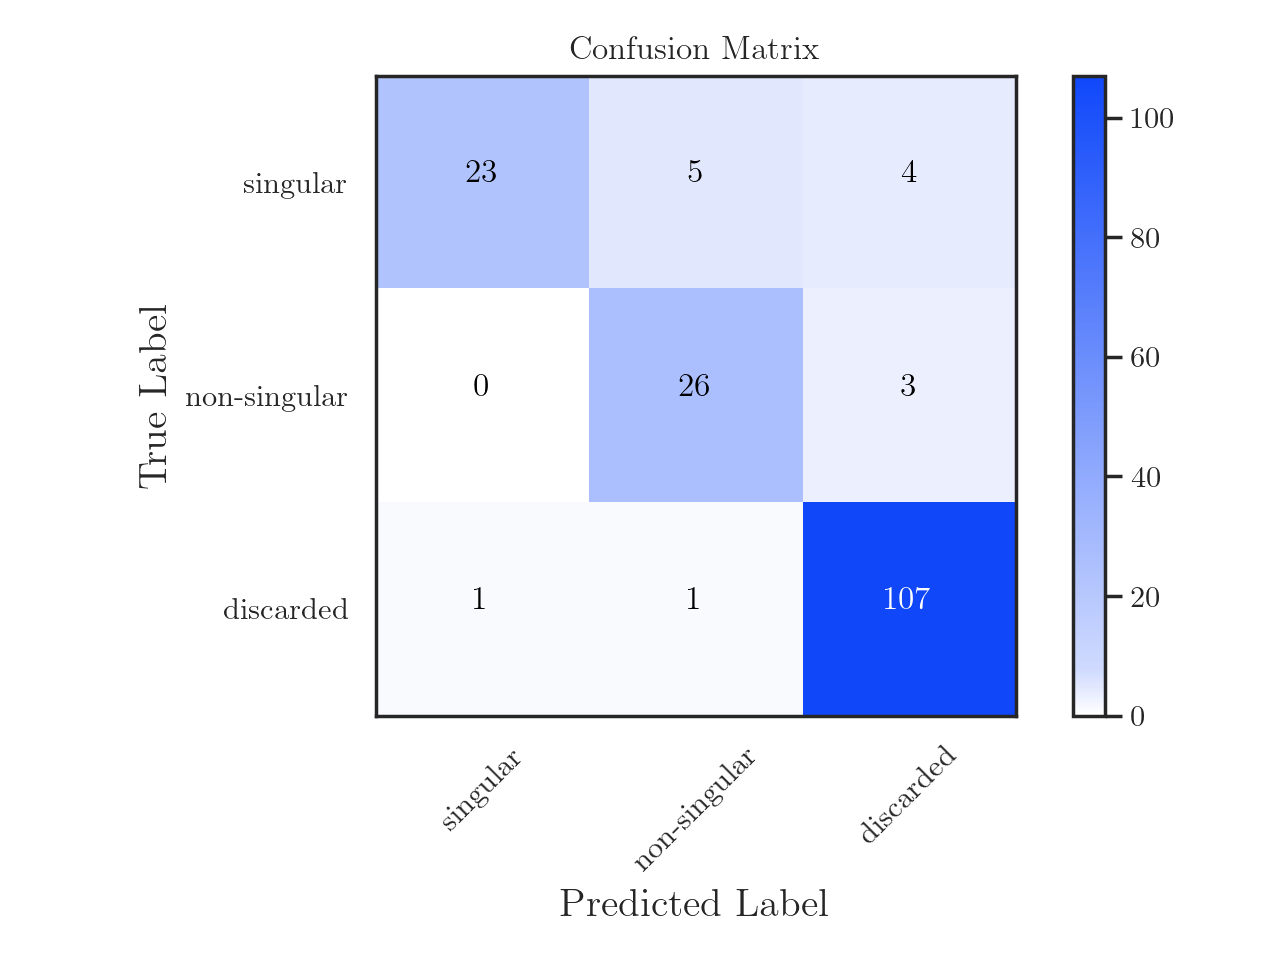

Confusion matrix, without normalization
[[ 23   5   4]
 [  0  26   3]
 [  1   1 107]]


In [22]:
#https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style("white")
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontsize="large")
    plt.xlabel('Predicted Label', fontsize="large")
    plt.tight_layout()
    fig.savefig("ML_confusion_matrix.pdf") #ML_confusion_matrix_testing_cm
    fig.savefig("ML_confusion_matrix.png", dpi=600, transparent=True)
    
cm = confusion_matrix(y_true=Y_corresponding, y_pred=predicitions_array)
cm_plot_labels = ["singular", "non-singular", "discarded"]

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix',cmap=newcmp)

## Bayesian Interference

\begin{equation}
P(B|A) = \frac{P(A|B) \cdot P(B)}{P(A)} \qquad \text{Bayes' theorem}
\end{equation}

\begin{equation}
P(\text{g2-singular}|\text{ML-singular}) = \frac{P(\text{ML-singular}|\text{g2-singular}) \cdot P(\text{g2-singular})}{P(\text{ML-singular})} \qquad \text{our application}
\end{equation}

In [23]:
P_ML_singular_given_g2_singular = cm[0][0] / sum(cm[0])
P_ML_singular = sum(cm[:,0]) / sum(sum(cm))
P_g2_singular = sum(cm[0]) / sum(sum(cm))
P_g2_singular_given_ML_singular = cm[0,0]/sum(cm[:,0]) #P_ML_singular_given_g2_singular * P_g2_singular / P_ML_singular
P_g2_non_singular_given_ML_non_singular = cm[1,1]/sum(cm[:,1])

print("P_ML_singular_given_g2_singular","\t", P_ML_singular_given_g2_singular, cm[0][0], "/", sum(cm[0]))
print("P_ML_singular","\t","\t","\t","\t", P_ML_singular, sum(cm[:,0]), "/", sum(sum(cm)))
print("P_g2_singular","\t","\t","\t","\t", P_g2_singular,  (sum(cm[0])), "/", sum(sum(cm)))
print("P_g2_singular_given_ML_singular","\t", P_g2_singular_given_ML_singular)
print("P_g2_non_sing_given_ML_non_singular","\t", P_g2_non_singular_given_ML_non_singular,  cm[1,1], "/", sum(cm[:,1]))

P_ML_singular_given_g2_singular 	 0.71875 23 / 32
P_ML_singular 	 	 	 	 0.1411764705882353 24 / 170
P_g2_singular 	 	 	 	 0.18823529411764706 32 / 170
P_g2_singular_given_ML_singular 	 0.9583333333333334
P_g2_non_sing_given_ML_non_singular 	 0.8125 26 / 32


### After this no more ML
I want to create the same confusion matrix I have here but based on different data. Therefore, I will manually add the datapoints

In [ ]:
cm = np.array([[23, 9],[3, 26]])
cm_plot_labels = ["singular", "non-singular"]

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix',cmap=newcmp)